# Nebula Award Winner Prediction

The aim of this work is to evaluate winning chances in Nebula Award (Novel category) using information about the author (gender, age, previous awards) and the novel (book genre).

## Dataset Сharacteristic

The information in the dataset is about all authors who have been nominated on Nebula Award in Novel category in the period from 1966 to 2022.

Sources where information about certain features were found:
- features from [**Science Fiction Awards Database**, or **SFAD**](http://www.sfadb.com/Nebula_Awards_2023):
    + **author** - nominated author's name;
    + **previous_awards** - information about author's previous awards (*"debutant"* for authors who have never been nominated<sup>[1](#1)</sup> before, *"ex_nominee"* for those who was nominated<sup>[1](#1)</sup> at least once, *"ex_winner"* for those who won<sup>[1](#1)</sup> at least once);
    + **title** - title of the book author was nominated for;
    + **award_year** - year when the author was nominated<sup>[2](#2)</sup>;
    + **publisher** - publishing house who first released the book;
    + **winner** - information about award author got (*"0"* for nominees, *"1"* for winners);
- features from [**Laboratoria Fantastiki**, or **FantLab**](https://fantlab.ru/award3), [**Goodreads**](https://www.goodreads.com/), **Wikipedia**, **authors' personal websites** and other **open sources**:
    + **gender** - author's gender (*"female"* for females, *"male"* for males);
    + **birth_year** - year when the author was born;
    + **genre** - book kind (*"SF"* for Science Fiction, *"Fantasy"* for Fantasy Literature<sup>[3](#3)</sup>);
- feature **age** - calculated as difference between **award_year** and **birth_year**.

As a result, there are 364 positions (numbered from 0 to 363) with 359 books written by 198 different authors.

***
<a name="1">1</a>: Nebula Award, Novel category

<a name="2">2</a>: According to the rules, Nebula Award is numbered with eligibility year - the year of book first publication, not by the award year: for example, the Nebula Award-1965 was awarded in 1966; *but* in this work they are numbered by award year as on SFAD website.

<a name="3">3</a>: Including magic realism, mystic and horror stories.
***

## Special cases

1. There is one "tie" situation (see pos. 348-349). Both authors were marked as winners.
2. There are five collaborations (see pos. 174-175, 188-189, 277-278, 298-299, 353-354). Authors were written separatelly in order not to loose information about each of them.
3. There are two situations when birth_year was unknown (see pos. 3, 59). Each were replaced with median value for authors nominated the same year.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.special as special
import pymc as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

ModuleNotFoundError: No module named 'pymc'

In [2]:
df = pd.read_csv('Nebula_dataset.csv')
df

,author,gender,birth_year,age,previous_awards,title,award_year,genre,publisher,winner
0,P. Djèlí Clark,male,1971,51,debutant,A Master of Djinn,2022,Fantasy,Tordotcom; Orbit UK,1
1,Arkady Martine,female,1985,37,ex_nominee,A Desolation Called Peace,2022,SF,Tor; Tor UK,0
2,S. B. Divya,female,1972,50,debutant,Machinehood,2022,SF,Saga,0
3,Jason Sanford,male,1979,43,debutant,Plague Birds,2022,SF,Apex,0
4,C. L. Clark,female,1986,36,debutant,The Unbroken,2022,Fantasy,Orbit,0
...,...,...,...,...,...,...,...,...,...,...
359,Keith Laumer,male,1925,41,debutant,A Plague of Demons,1966,SF,Berkley,0
360,Avram Davidson,male,1923,43,debutant,Rogue Dragon,1966,SF,Ace,0
361,G. C. Edmondson,male,1922,44,debutant,The Ship That Sailed the Time Stream,1966,SF,Ace,0
362,Poul Anderson,male,1926,40,debutant,The Star Fox,1966,SF,Doubleday,0


## Shortened EDA

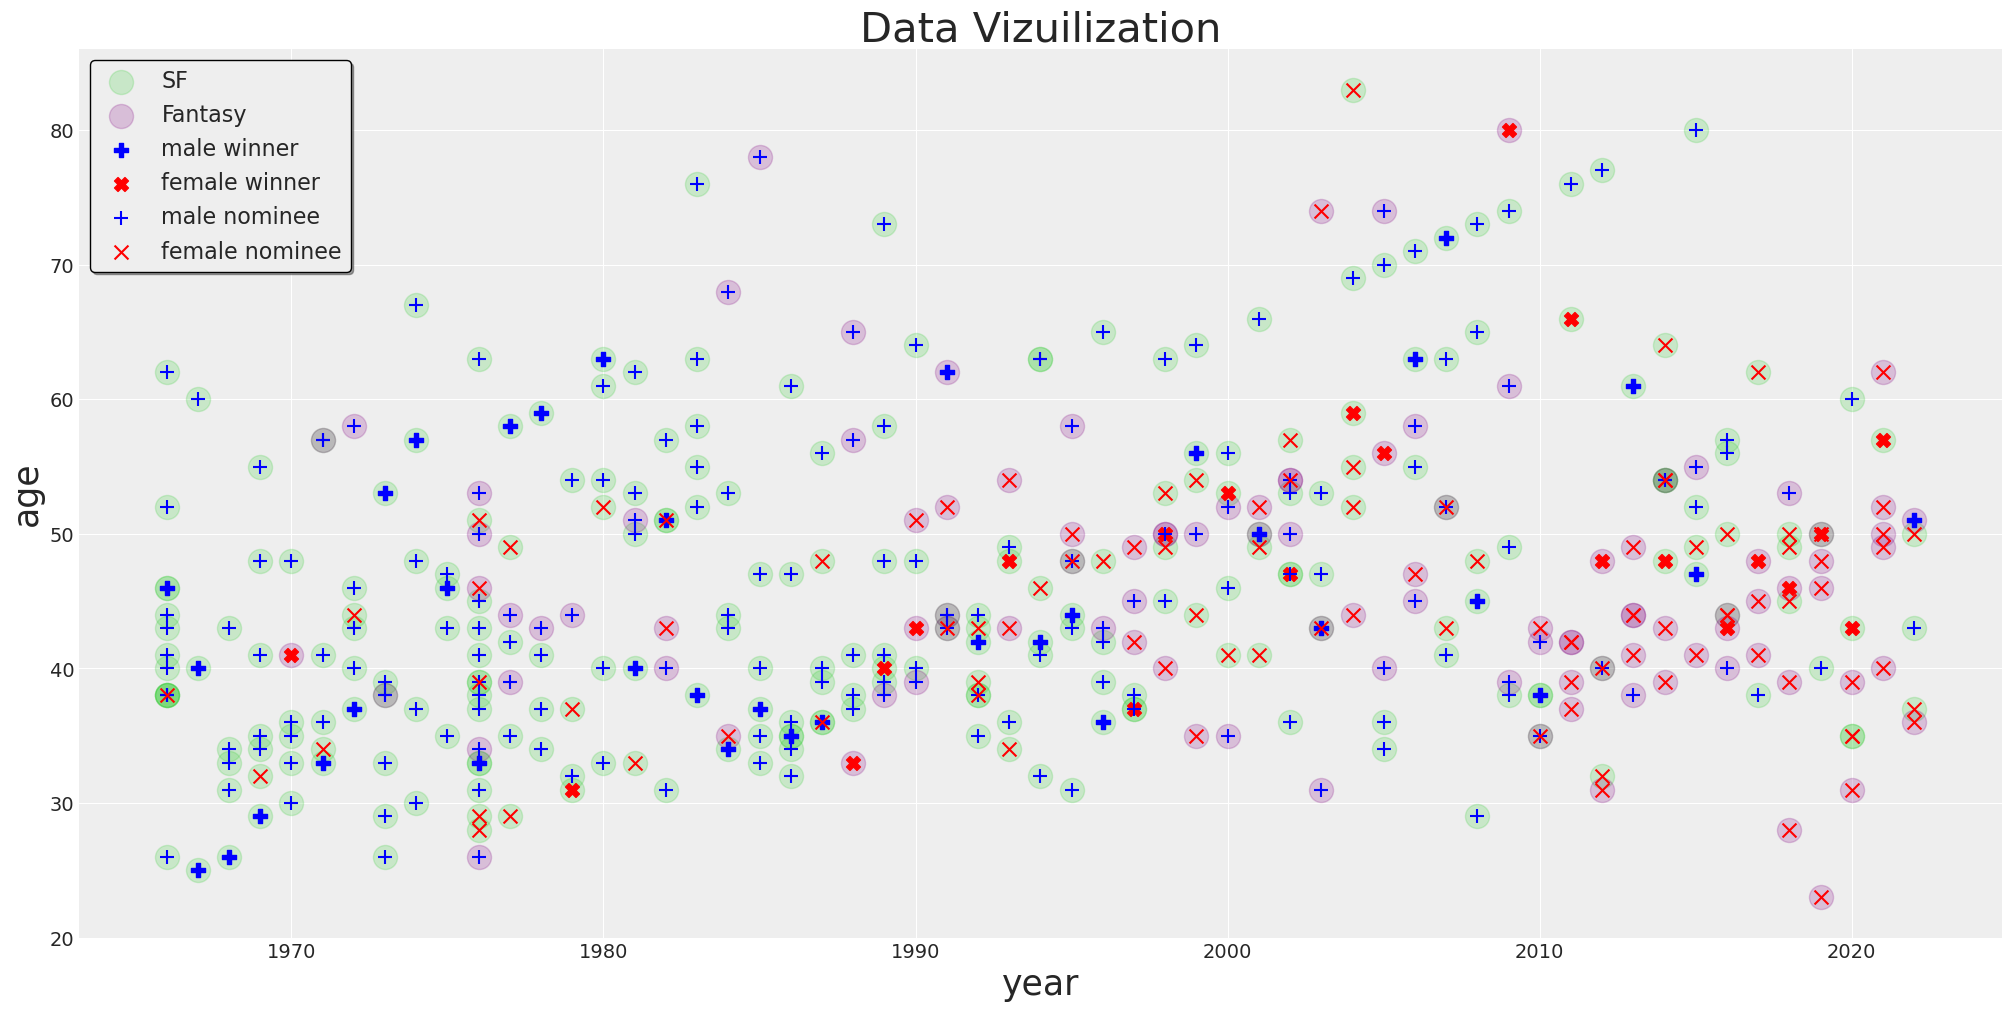

In [3]:
plt.figure(figsize=(20,10))

plt.scatter(df[df['genre'] == 'SF'].award_year, df[df['genre'] == 'SF'].age,
            marker='o', label='SF', c='limegreen', s=300, alpha=0.2)
plt.scatter(df[df['genre'] == 'Fantasy'].award_year, df[df['genre'] == 'Fantasy'].age,
            marker='o', label='Fantasy', c='purple', s=300, alpha=0.2)

plt.scatter(df[(df['gender'] == 'male') & (df['winner'] == 1)].award_year,
            df[(df['gender'] == 'male') & (df['winner'] == 1)].age,
            marker='P', label='male winner', s=100,  c='blue')
plt.scatter(df[(df['gender'] == 'female') & (df['winner'] == 1)].award_year,
            df[(df['gender'] == 'female') & (df['winner'] == 1)].age,
            marker='X', label='female winner', s=100,  c='red')

plt.scatter(df[(df['gender'] == 'male') & (df['winner'] == 0)].award_year,
            df[(df['gender'] == 'male') & (df['winner'] == 0)].age,
            marker='+', label='male nominee', s=100, c='blue')
plt.scatter(df[(df['gender'] == 'female') & (df['winner'] == 0)].award_year,
            df[(df['gender'] == 'female') & (df['winner'] == 0)].age,
            marker='x', label='female nominee', s=100,  c='red')

plt.title('Data Vizuilization', fontsize=30)
plt.legend(loc='upper left', shadow=True, edgecolor='k', frameon='True', fontsize=16)
plt.xlabel('year', fontsize=25)
plt.ylabel('age', fontsize=25)

plt.show()

In data visualization above we can see several potentially possible trends:
- increasing number of women among both winners and nominees
- increasing number of fantastic novels among winners' and nominees' works

The graphs below show this trends more clearly.

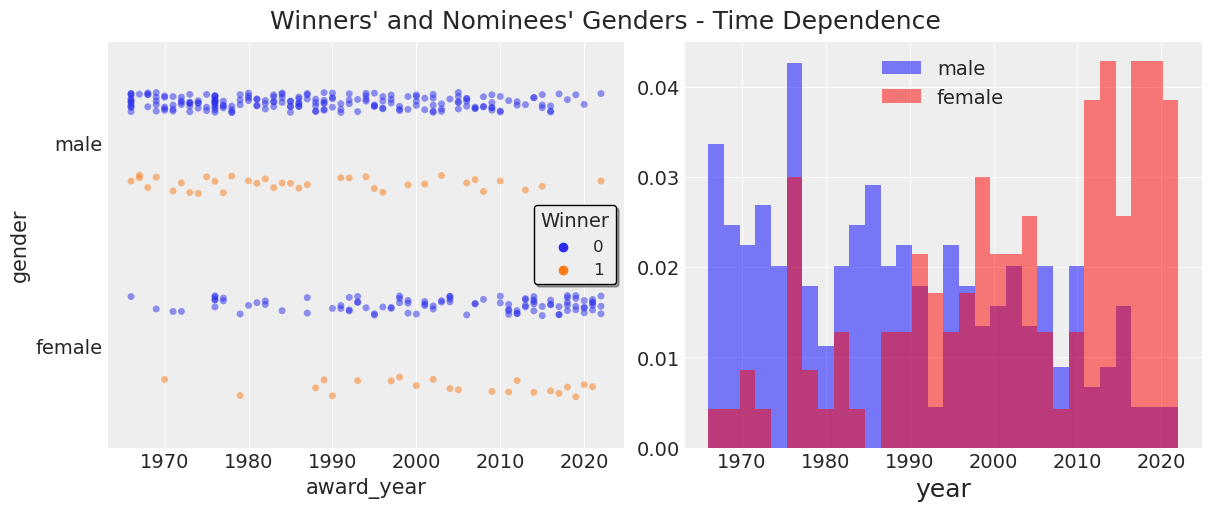

In [4]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
chart = sns.stripplot(data=df.query("gender in ['male', 'female']"), x="award_year", y="gender", orient="h",
                      hue="winner", dodge=True, jitter=True, alpha=0.5)
plt.legend(loc='center right', shadow=True, edgecolor='k', frameon='True', fontsize=12, title='Winner', title_fontsize=14)

plt.subplot(1, 2, 2)
plt.xlabel('year', fontsize=18)
_, bins, _ = plt.hist(df[df.gender=='male'].award_year, bins=30, range=[1966, 2022], 
                      density=True, alpha=0.5, color='blue', label='male')
plt.hist(df[df.gender=='female'].award_year, bins=bins, density=True, alpha=0.5, color='red', label='female')
plt.legend()

fig.suptitle("Winners' and Nominees' Genders - Time Dependence", fontsize=18)
plt.show()

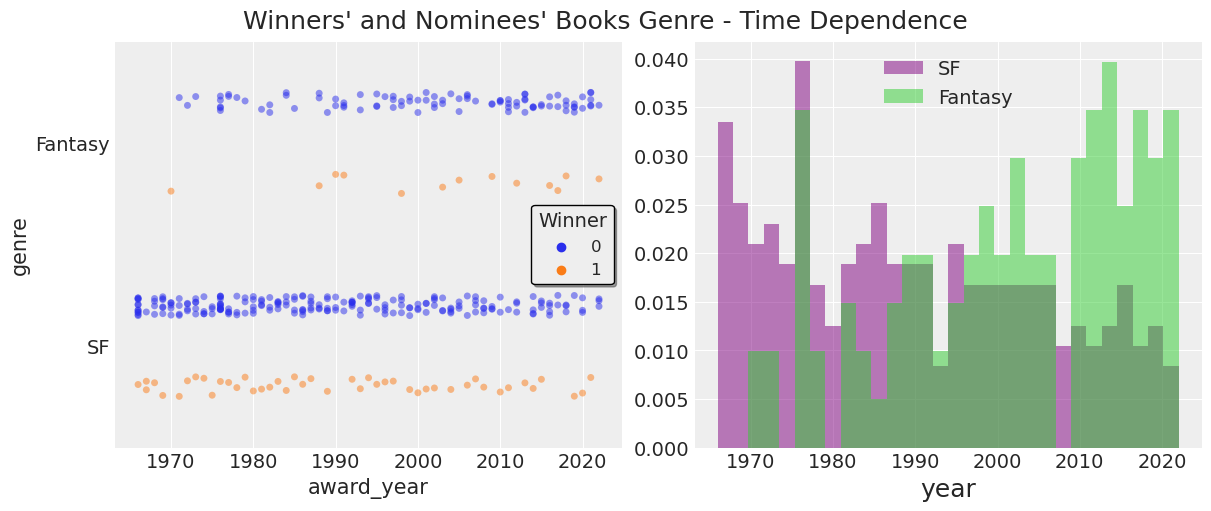

In [5]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
chart = sns.stripplot(data=df.query("genre in ['SF', 'Fantasy']"), x="award_year", y="genre", orient="h",
                      hue="winner", dodge=True, jitter=True, alpha=0.5)
plt.legend(loc='center right', shadow=True, edgecolor='k', frameon='True', fontsize=12, title='Winner', title_fontsize=14)

plt.subplot(1, 2, 2)
plt.xlabel('year', fontsize=18)
_, bins, _ = plt.hist(df[df.genre=='SF'].award_year, bins=30, range=[1966, 2022], 
                      density=True, alpha=0.5, color='purple', label='SF')
plt.hist(df[df.genre=='Fantasy'].award_year, bins=bins, density=True, alpha=0.5, color='limegreen', label='Fantasy')
plt.legend()

fig.suptitle("Winners' and Nominees' Books Genre - Time Dependence", fontsize=18)
plt.show()

Other categories (**age** and **previous_awards**) were also checked on time dependance. As a result, **age** is suspected to increase with time and **previous_awards** is believed not to correlate with time. All the correlation is shown below.

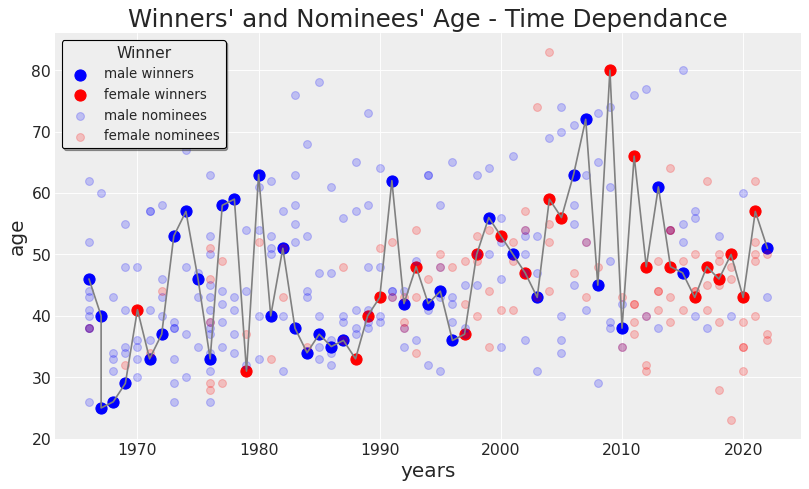

In [6]:
plt.figure(figsize=(10, 6), dpi= 80)

plt.plot(df[df.winner == 1].award_year.values, df[df.winner == 1].age.values, lw=1.5, color = 'grey')
plt.scatter(df[(df.gender == 'male') & (df.winner == 1)].award_year.values,
            df[(df.gender == 'male') & (df.winner == 1)].age.values,
           color='blue', label='male winners', s=100)
plt.scatter(df[(df.gender == 'female') & (df.winner == 1)].award_year.values,
            df[(df.gender == 'female') & (df.winner == 1)].age.values,
           color='red', label='female winners', s=100)     
plt.scatter(df[(df.gender == 'male') & (df.winner == 0)].award_year.values,
            df[(df.gender == 'male') & (df.winner == 0)].age.values,
           color='blue', label='male nominees', s=50, alpha=0.2)
plt.scatter(df[(df.gender == 'female') & (df.winner == 0)].award_year.values,
            df[(df.gender == 'female') & (df.winner == 0)].age.values,
           color='red', label='female nominees', s=50, alpha=0.2) 

plt.title("Winners' and Nominees' Age - Time Dependance", fontsize=22)  
plt.xlabel("years", fontsize=18)
plt.ylabel("age", fontsize=18)
plt.legend(loc='upper left', shadow=True, edgecolor='k', frameon='True', fontsize=12, title='Winner', title_fontsize=14)

plt.show()

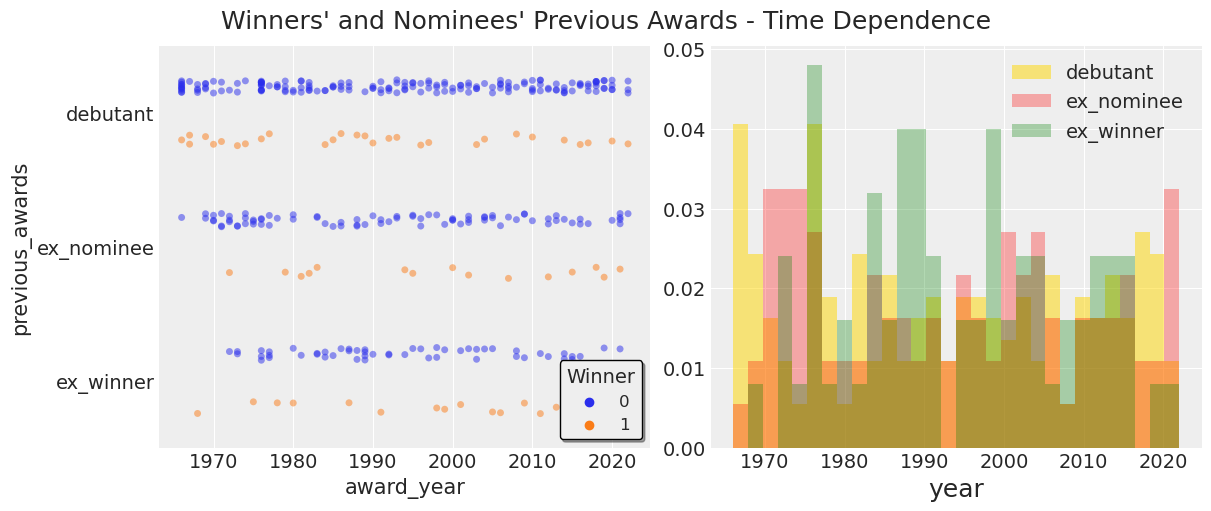

In [7]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
chart = sns.stripplot(data=df.query("previous_awards in ['debutant', 'ex_nominee', 'ex_winner']"),
                      x="award_year", y="previous_awards",
                      orient="h", hue="winner", dodge=True, jitter=True, alpha=0.5)
plt.legend(loc='lower right', shadow=True, edgecolor='k', frameon='True', fontsize=12, title='Winner', title_fontsize=14)

plt.subplot(1, 2, 2)
plt.xlabel('year', fontsize=18)
_, bins, _ = plt.hist(df[df.previous_awards=='debutant'].award_year, bins=30, range=[1966, 2022], 
                      density=True, alpha=0.5, color='gold', label='debutant')
plt.hist(df[df.previous_awards=='ex_nominee'].award_year, bins=bins, density=True, alpha=0.3, color='red', label='ex_nominee')
plt.hist(df[df.previous_awards=='ex_winner'].award_year, bins=bins, density=True, alpha=0.3, color='green', label='ex_winner')
plt.legend()

fig.suptitle("Winners' and Nominees' Previous Awards - Time Dependence", fontsize=18)
plt.show()

## Hypothesis and Model

According to the plots above:
- time (**award_year**) seems to influence winners' and nominees' **gender**, **age** and **genre** features in monotonous way;
- **previous_awards** appears to be independent of time.

It is also assumed that **gender**, **age**, **genre**, **previous_awards** is independent from each other.

Because of that following hypothesis has been formulated. We can split the task into several stages.

On the first stage we use bayesian linear regression on **age** feature to find how it depends on time.

On the second stage we use bayesian logistic regression to find how **award_year** and **previous_awards** influence target variable **winner**.

On the third stage we express how **age** influence **winner** in terms of **award_year** influnce on **winner**. It is possible as both dependences are linear<sup>[4](#4)</sup>.

***
**1 stage**
***
- First-stage target **age** is defind as $x_1$, independent variable **award_year** is defined as $y$.
- According to the hypothesis $x_1^i = \alpha + \beta y^i + \epsilon$.

<p style="text-align: center;">
<b>
Linear Regression
</b>
</p>
  
$$
\mathbf x_1 | \mathbf y; \alpha, \beta, \epsilon \sim \mathrm{N}(\mu_{\alpha} + \mu_{\beta} \mathbf y, \epsilon)
\\
\alpha \sim \mathrm{N}(\mu_{\alpha}, \sigma_{\alpha})
\\
\beta \sim \mathrm{N}(\mu_{\beta}, \sigma_{\beta})
\\
\epsilon \sim \mathrm{HalfNormal}(0, \sigma_{\epsilon})
$$ 
***
As a result we get knowledge about how $y$ influence feature $x_1$: coefficients $\alpha, \beta, \epsilon$.
***
**2 stage**
***
- Second-stage target **winner** is defined as $t$, one of the independent variables **previous_awards** is defined as $x_2$
- According to the hypothesis $t^i \sim \mathrm{Be}(\sigma(p + q y^i + c[0] x_2^i[0] + c[1] x_2^i[1] + c[2] x_2^i[2]))$ <sup>[5](#5)</sup>.
   
<p style="text-align: center;">
<b>
Logistic Regression
</b>
</p>

$$
\mathbf t | \mathbf y, \mathbf x_2; a, b, \mathbf c \sim \mathrm{Be}(\theta(\mathbf y, \mathbf x_2))
\\
\theta(\mathbf y, \mathbf x_2) = \sigma(a \mathbf 1 + b \mathbf y + \mathbf c^T \mathbf x_2)
\\
p \sim \mathrm{N}(M_0, S_0)
\\
q \sim \mathrm{N}(M_1, S_1)
\\
c[i] \sim \mathrm{N}(M_{2i}, S_{2i}), i=0,1,2.
$$
***
As a result we get knowledge about how $y$ (through $x_1$) and $x_2$ (directly) influence target variable $t$: coefficients $a, b, \mathbf c$.
***
**3 stage**
***
$$
t^i \sim \mathrm{Be}(\sigma(p + q y^i + c[0] x_2^i[0] + c[1] x_2^i[1] + c[2] x_2^i[2])) = \mathrm{Be}(\sigma(a * \mathbf 1 + b x_1^i + c[0] x_2^i[0] + c[1] x_2^i[1] + c[2] x_2^i[2]))
$$

<p style="text-align: center;">
<b>
System of equations (express a and b in term of p and q ($\alpha, \beta$ and $\epsilon$ are known from previous stage)):
</b>
</p>

$$
a + b (\alpha + \epsilon) = p,
\\
b \beta = q
$$

$$
a = p - q : \beta * (\alpha + \epsilon),
\\
b = q : \beta
$$
***
Coefficients $a, b, \mathbf c$ are used in prediction of $t_{new}$.

***
***
<a name="4">4</a>: That's why the such algorithm can't be used with **gender** and **genre** features.

<a name="5">5</a>: In programm coefficients $p, q, c[0], c[1], c[2]$ are stored in matrix $w$.

## Data Preprocessing

In [8]:
df = df.drop(['author', 'gender', 'birth_year', 'title', 'genre', 'publisher'], axis=1)
tmp = pd.get_dummies(df['previous_awards'])
df = df.drop(['previous_awards'], axis=1)
df = df.join(tmp)
df

,age,award_year,winner,debutant,ex_nominee,ex_winner
0,51,2022,1,1,0,0
1,37,2022,0,0,1,0
2,50,2022,0,1,0,0
3,43,2022,0,1,0,0
4,36,2022,0,1,0,0
...,...,...,...,...,...,...
359,41,1966,0,1,0,0
360,43,1966,0,1,0,0
361,44,1966,0,1,0,0
362,40,1966,0,1,0,0


## Linear Regression: Age

In [9]:
y_label = 'award_year'
y = df[y_label]
y_mean = y.mean()
y_scale = y.std()
y = (y - y_mean) / y_scale

x1_label = 'age'
x1 = df[x1_label]
x1_mean = x1.mean()
x1_scale = x1.std()
x1 = (x1 - x1_mean) / x1_scale

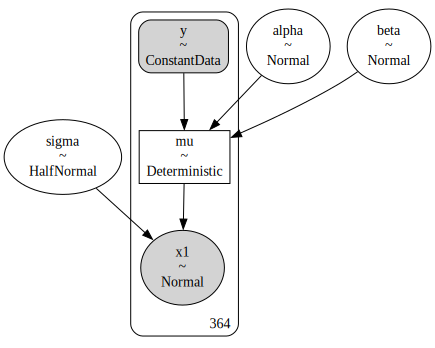

In [10]:
with pm.Model() as linreg_model:
    Y_data = pm.ConstantData("y", y)
    alpha = pm.Normal('alpha', mu=0, sigma=np.array(10))
    beta = pm.Normal('beta', mu=0, sigma=np.array(2))
    sigma = pm.HalfNormal('sigma', sigma=2)
    mu = pm.Deterministic('mu', alpha + beta*Y_data)
    outputs1 = pm.Normal('x1', mu=mu, sigma=sigma, observed=x1)
    
pm.model_to_graphviz(linreg_model)

In [11]:
with linreg_model:
    inf_data1 = pm.sample(draws=2000, tune=1000, chains=4, cores=2,
                         return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


In [12]:
az.summary(inf_data1, var_names=['alpha', 'beta', 'sigma'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.05,-0.09,0.10,0.0,0.0,11681.60,5443.05,1.0
beta,0.24,0.05,0.14,0.33,0.0,0.0,11823.83,6272.61,1.0
sigma,0.98,0.04,0.91,1.05,0.0,0.0,9887.02,6391.69,1.0


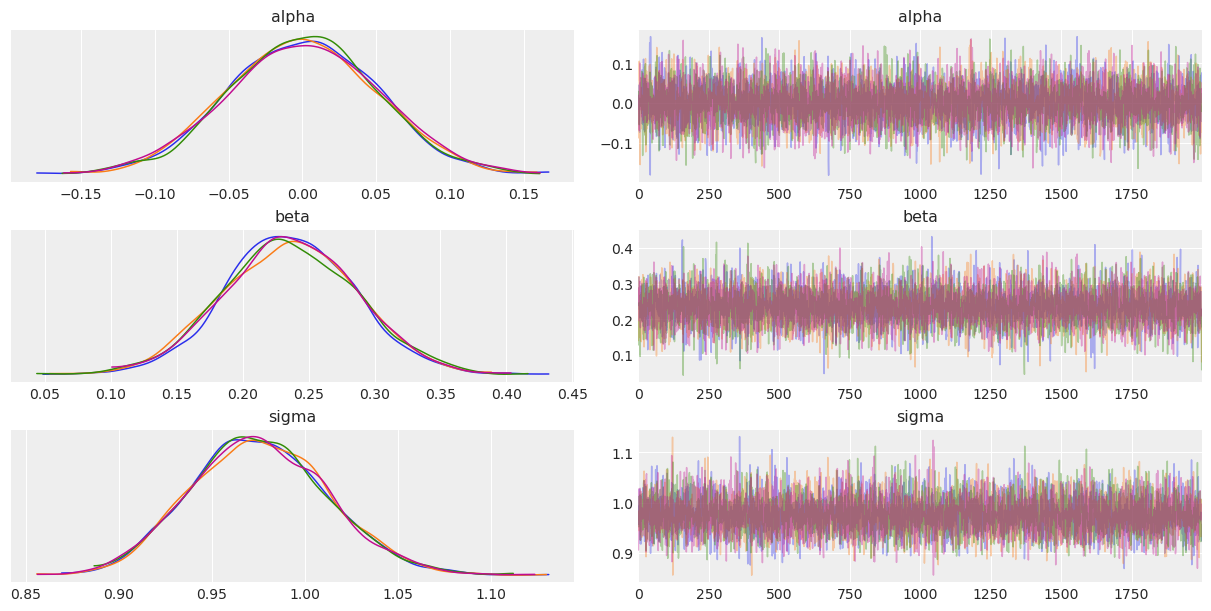

In [13]:
az.plot_trace(inf_data1, var_names=['alpha', 'beta', 'sigma'], compact=False);

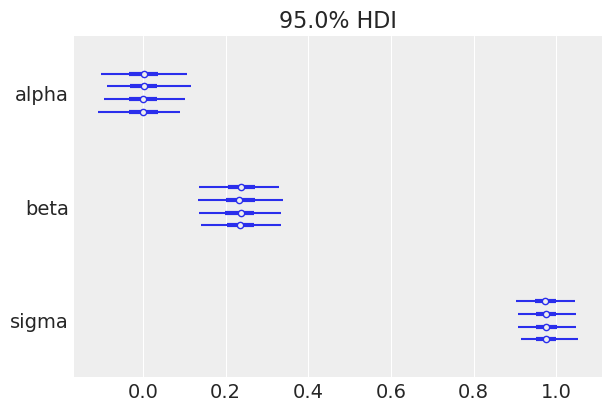

In [14]:
az.plot_forest(inf_data1, var_names=['alpha', 'beta', 'sigma'], hdi_prob=0.95, figsize=(6, 4));

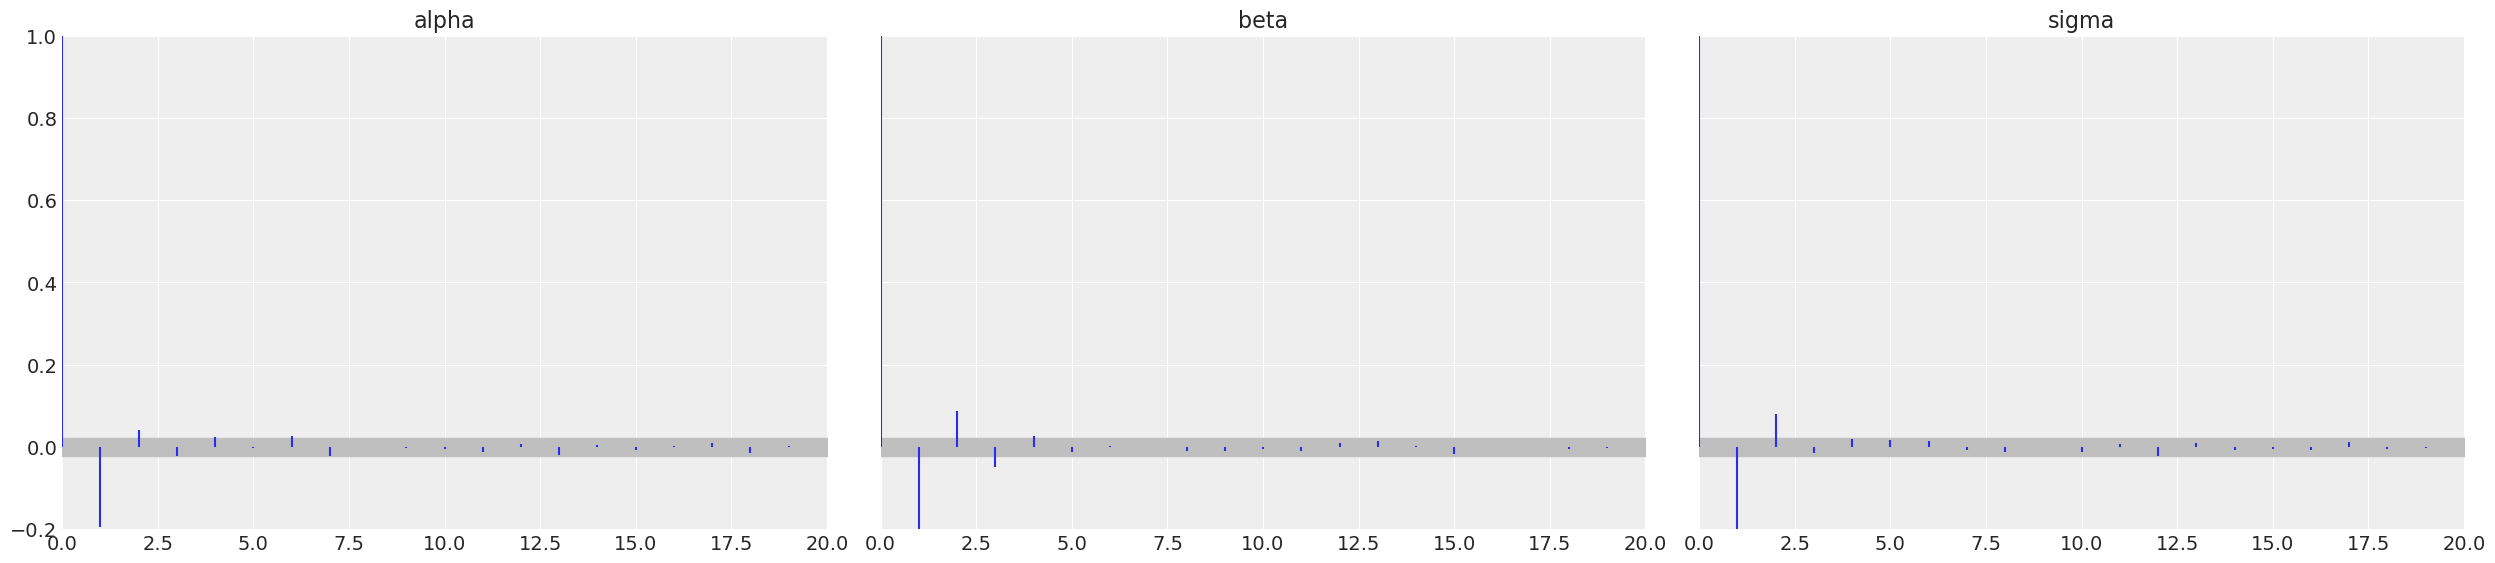

In [15]:
az.plot_autocorr(inf_data1, var_names=['alpha', 'beta', 'sigma'], max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

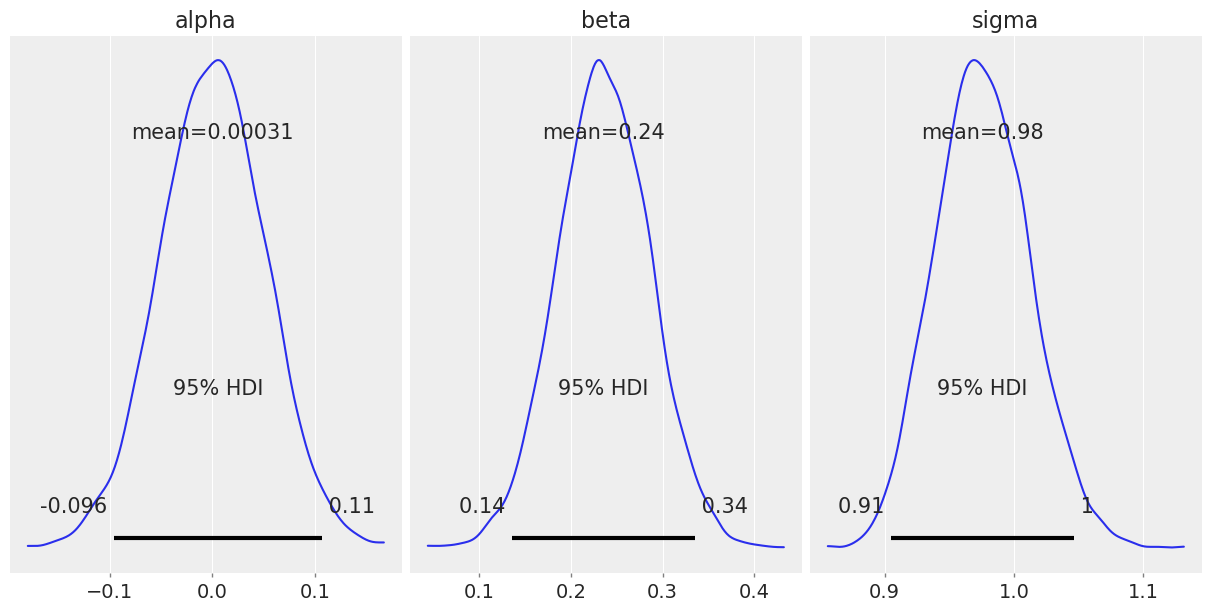

In [16]:
az.plot_posterior(inf_data1, var_names=['alpha', 'beta', 'sigma'], hdi_prob=0.95, figsize=(12,6));

In [17]:
alpha_trace = inf_data1.posterior['alpha'].values.flatten()
beta_trace = inf_data1.posterior['beta'].values.flatten()
sigma_trace = inf_data1.posterior['sigma'].values.flatten()

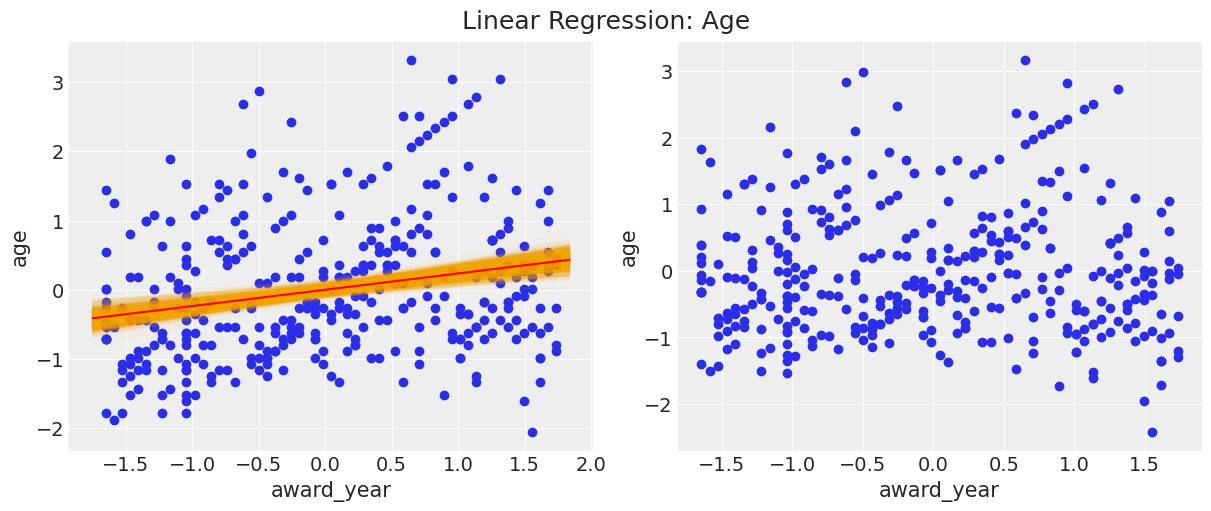

In [18]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(x=y, y=x1)
plt.xlabel(y_label)
plt.ylabel(x1_label)

x_grid = np.linspace(y.min()-0.1, y.max()+0.1, 2)
for i in np.arange(0, len(alpha_trace), 10):
    y_grid = alpha_trace[i] + beta_trace[i]*x_grid
    plt.plot(x_grid, y_grid, color='orange', alpha=0.05)
    
y_grid = alpha_trace.mean() + beta_trace.mean()*x_grid
plt.plot(x_grid, y_grid, color='red')

plt.subplot(1, 2, 2)
x1_copy = x1 - y * beta_trace.mean()

plt.scatter(x=y, y=x1_copy)
plt.xlabel(y_label)
plt.ylabel(x1_label)

fig.suptitle("Linear Regression: Age", fontsize=18)
plt.show()

## Logistic Regression: Winner

In [19]:
X = np.stack([y, df.debutant, df.ex_nominee, df.ex_winner], axis=-1)
t = df.winner
print('X.shape=', X.shape)
print('t.shape=', t.shape)
X

X.shape= (364, 4)
t.shape= (364,)


array([[ 1.73562276,  1.        ,  0.        ,  0.        ],
       [ 1.73562276,  0.        ,  1.        ,  0.        ],
       [ 1.73562276,  1.        ,  0.        ,  0.        ],
       ...,
       [-1.64603795,  1.        ,  0.        ,  0.        ],
       [-1.64603795,  1.        ,  0.        ,  0.        ],
       [-1.64603795,  1.        ,  0.        ,  0.        ]])

In [20]:
zX = X
zX = np.hstack([np.ones(shape=(zX.shape[0], 1)), zX])
zX

array([[ 1.        ,  1.73562276,  1.        ,  0.        ,  0.        ],
       [ 1.        ,  1.73562276,  0.        ,  1.        ,  0.        ],
       [ 1.        ,  1.73562276,  1.        ,  0.        ,  0.        ],
       ...,
       [ 1.        , -1.64603795,  1.        ,  0.        ,  0.        ],
       [ 1.        , -1.64603795,  1.        ,  0.        ,  0.        ],
       [ 1.        , -1.64603795,  1.        ,  0.        ,  0.        ]])

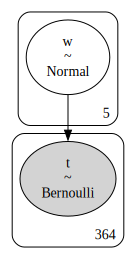

In [21]:
with pm.Model() as logistic_model:
    w = pm.Normal('w', mu=0, sigma=np.array([10, 2, 2, 2, 2]), shape=(5))  # sd=10 for w0 and sd=2 for predictors
    theta = pm.invlogit(pm.math.dot(w, zX.T))
    outputs = pm.Bernoulli('t', p=theta, observed=t)
    
pm.model_to_graphviz(logistic_model)

In [22]:
with logistic_model:
    inf_data2 = pm.sample(draws=2000, tune=1000, chains=4, cores=2,
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 67 seconds.


In [23]:
inf_data2.posterior['w'].shape

(4, 2000, 5)

In [24]:
az.summary(inf_data2, var_names=['w'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-1.63,1.17,-3.83,0.55,0.03,0.02,1906.59,2108.54,1.0
w[1],0.01,0.14,-0.24,0.29,0.00,0.00,3431.72,3364.31,1.0
w[2],-0.16,1.17,-2.30,2.12,0.03,0.02,1964.32,2173.00,1.0
w[3],-0.13,1.18,-2.29,2.14,0.03,0.02,1942.19,2174.08,1.0
w[4],0.26,1.18,-1.94,2.51,0.03,0.02,1927.16,1870.17,1.0


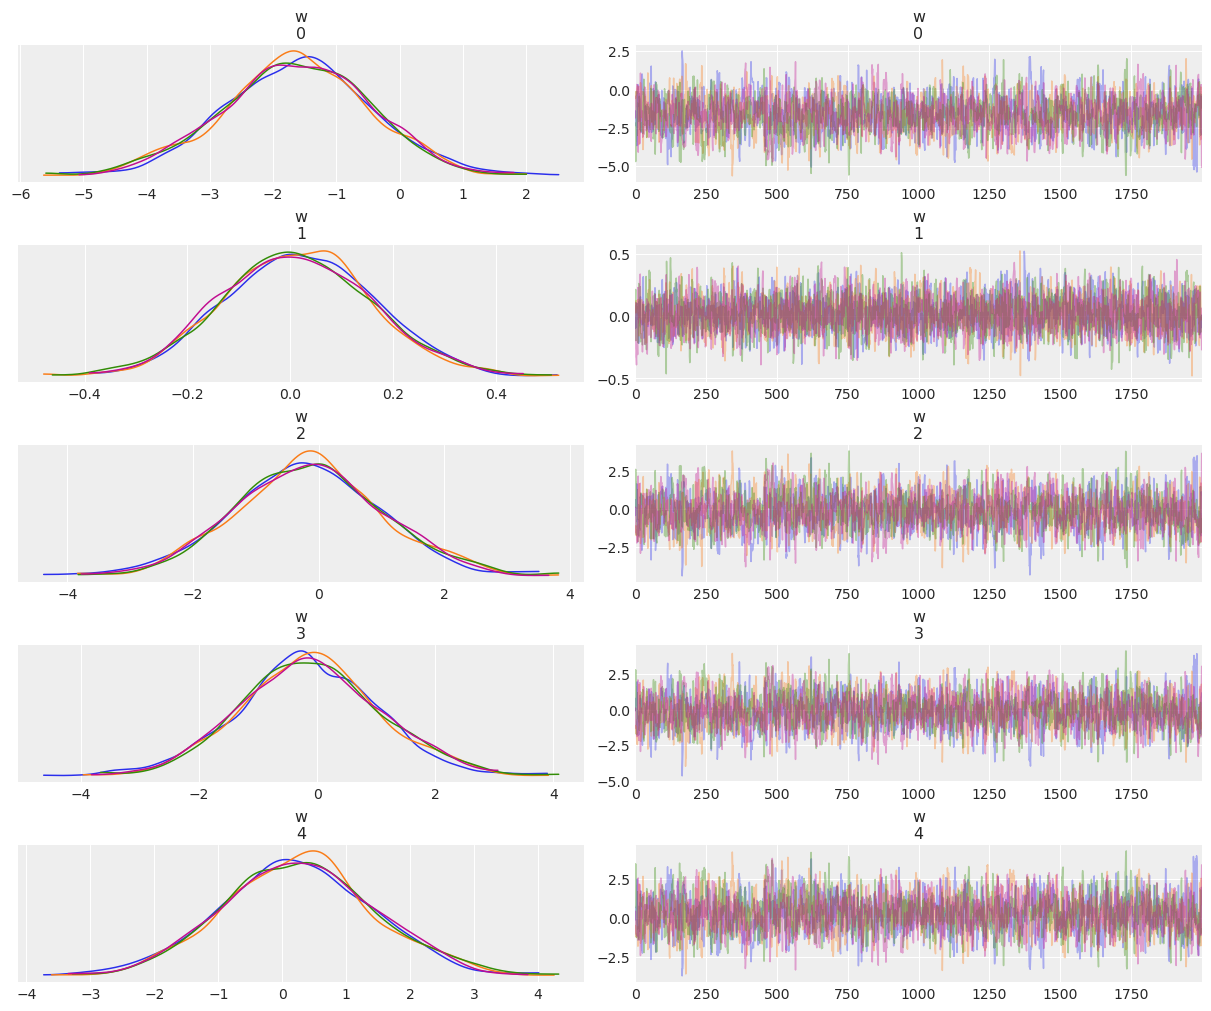

In [25]:
az.plot_trace(inf_data2, compact=False);

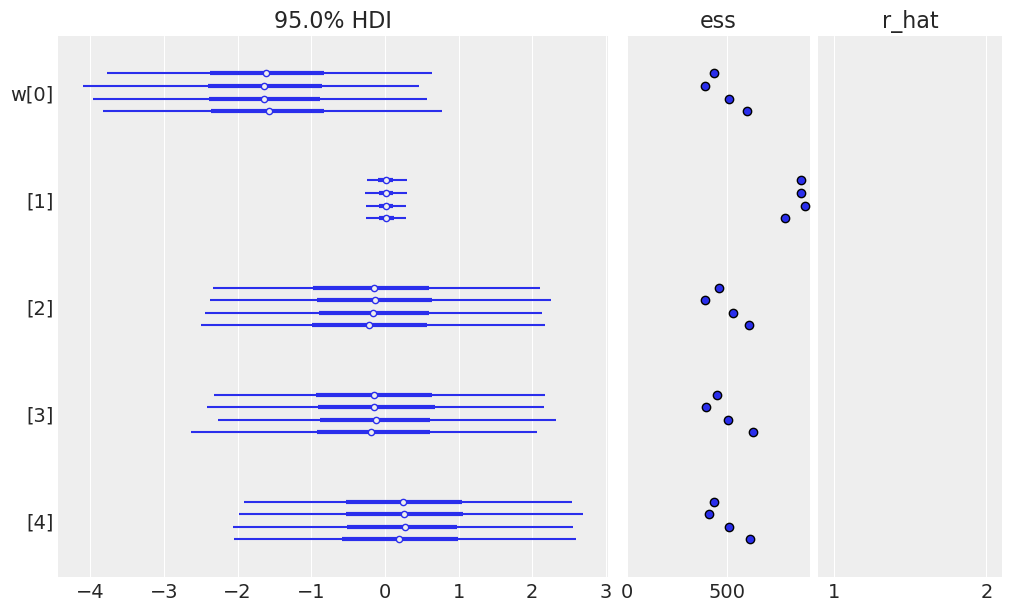

In [26]:
az.plot_forest(inf_data2, hdi_prob=0.95, r_hat=True, ess=True);

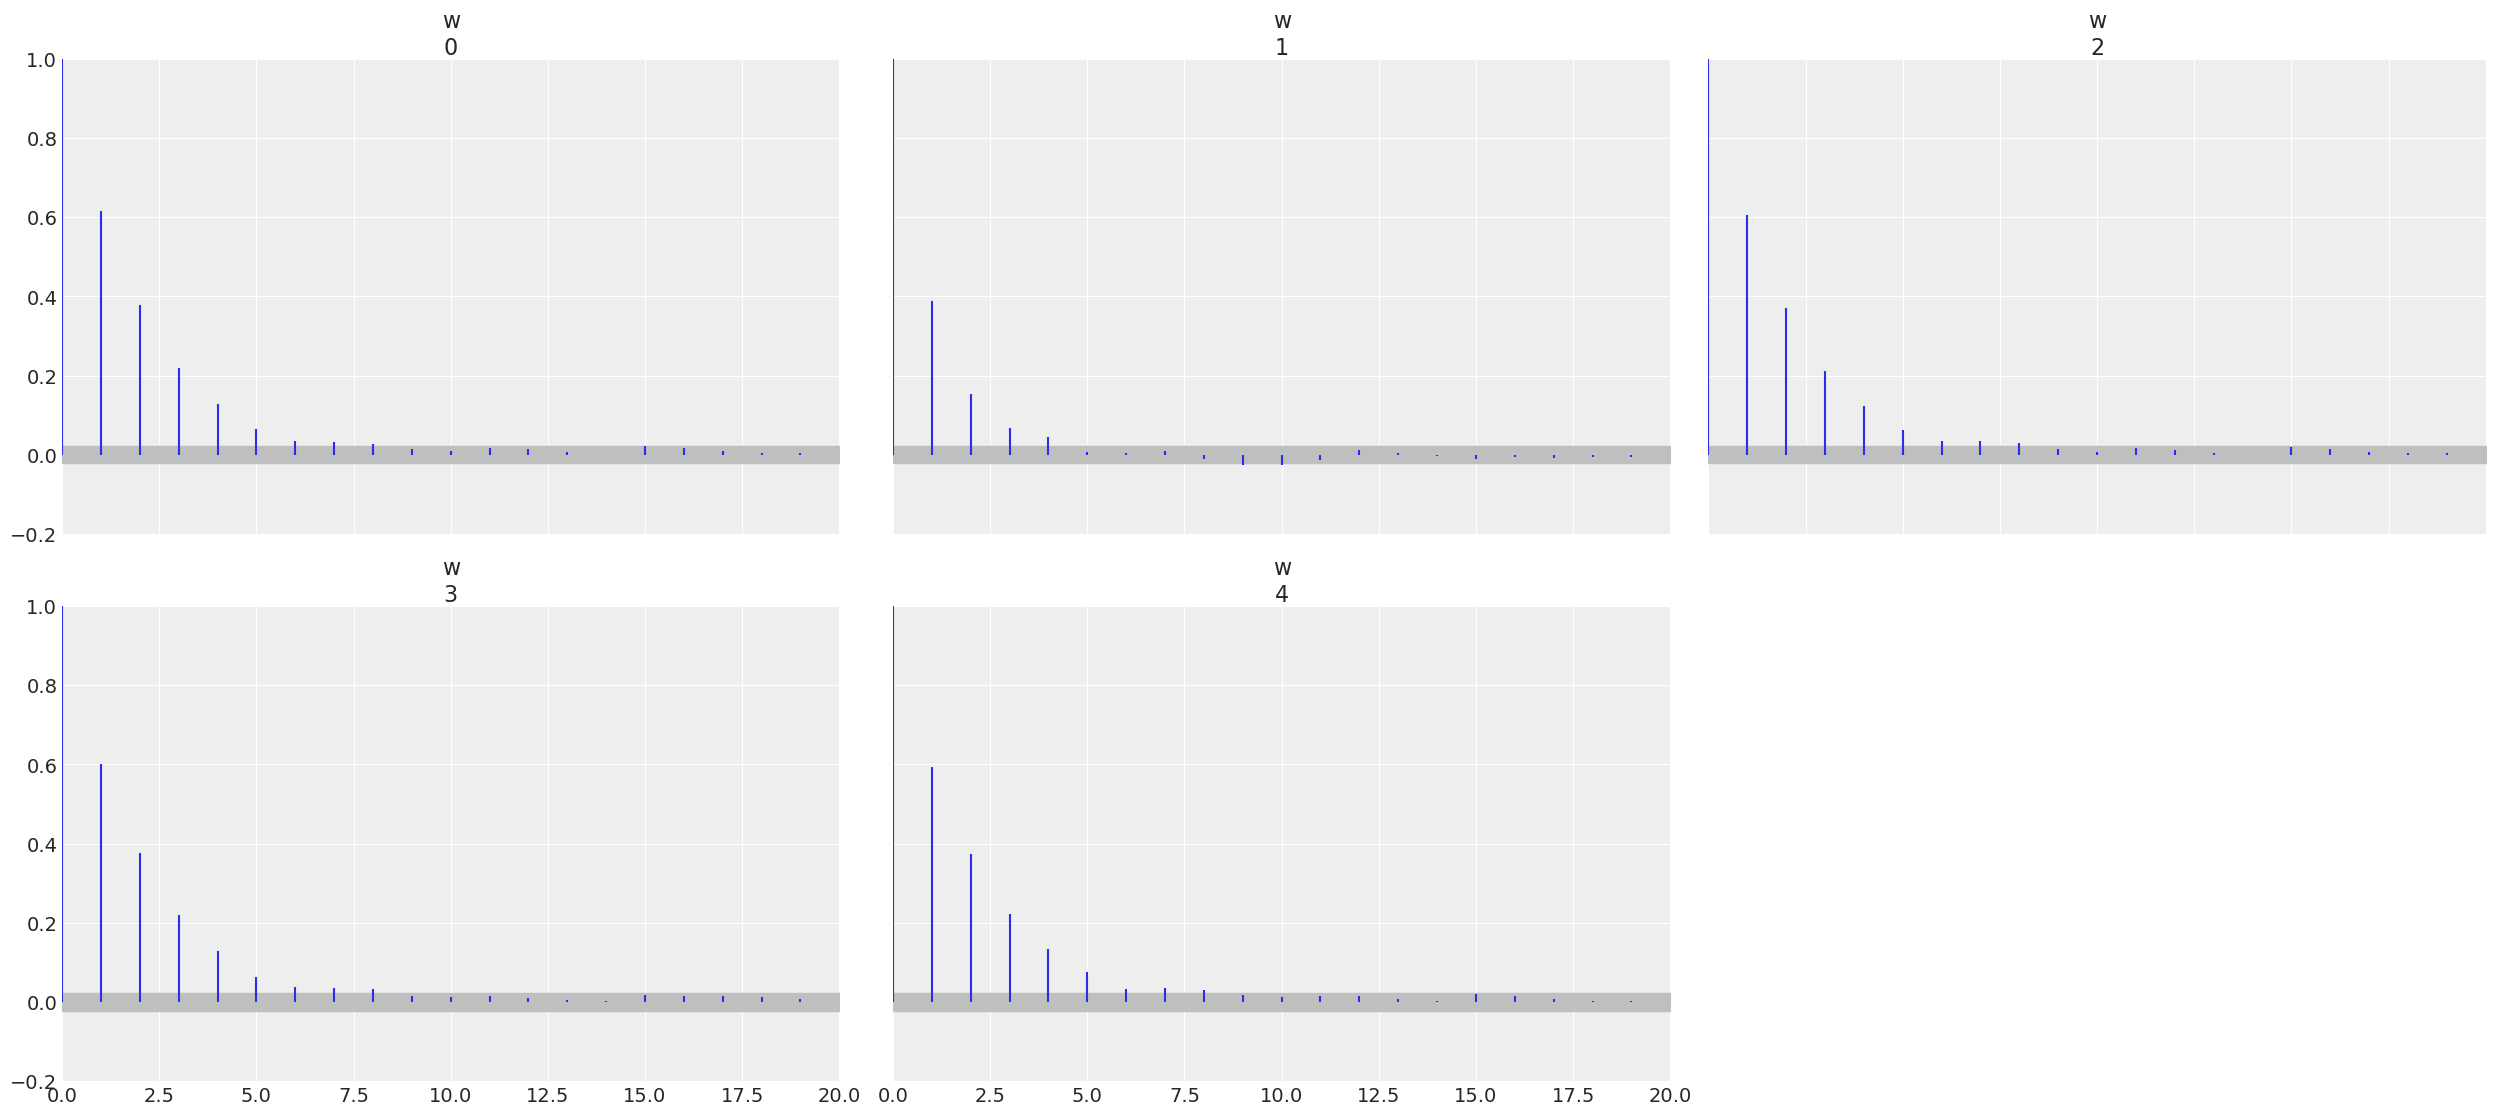

In [27]:
az.plot_autocorr(inf_data2, max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

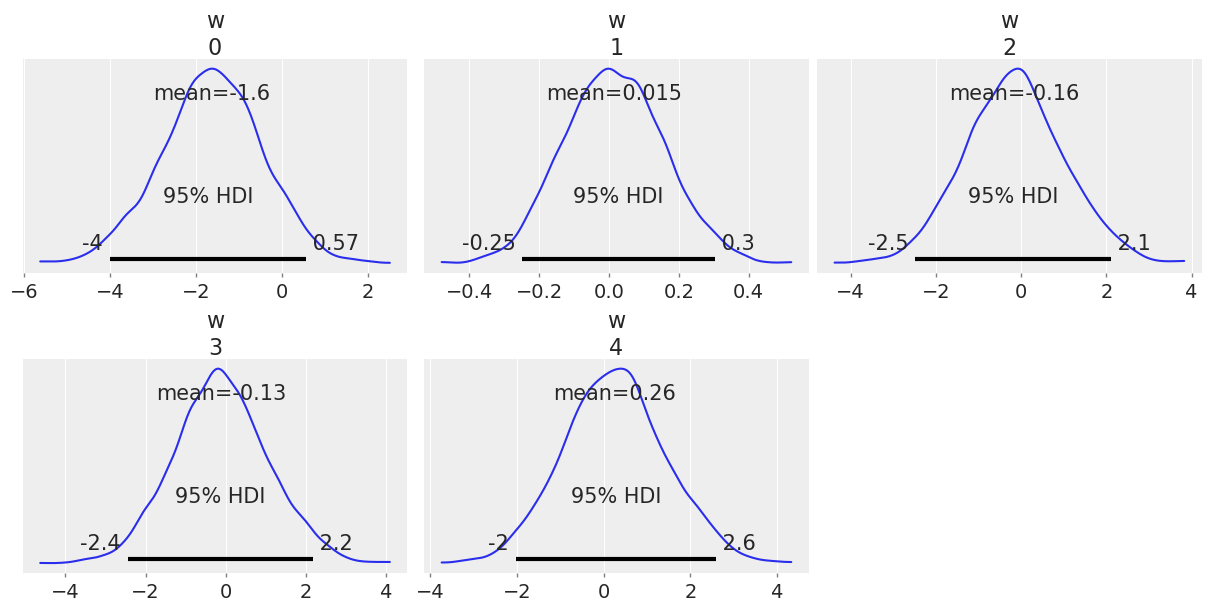

In [28]:
az.plot_posterior(inf_data2, hdi_prob=0.95, figsize=(12,6));

## Express coefficients in other terms

In [29]:
print(alpha_trace.mean(), beta_trace.mean(), sigma_trace.mean())

w0_trace = inf_data2.posterior['w'][...,0].values.reshape(-1)
w1_trace = inf_data2.posterior['w'][...,1].values.reshape(-1)
w2_trace = inf_data2.posterior['w'][...,2].values.reshape(-1)
w3_trace = inf_data2.posterior['w'][...,3].values.reshape(-1)
w4_trace = inf_data2.posterior['w'][...,4].values.reshape(-1)

w1_trace /= beta_trace.mean()
w0_trace -= w1_trace * (alpha_trace.mean() + sigma_trace.mean())

w_trace = np.stack([w0_trace, w1_trace, w2_trace, w3_trace, w4_trace], axis=-1)
w_trace

0.0003061412025860919 0.23568860862211655 0.9758939130773855


array([[-1.25259349, -0.41576273,  0.04721169, -0.09643002, -0.13417821],
       [-1.33968792, -0.05640815, -0.4131941 , -0.07022114, -0.09916714],
       [-1.73477051, -0.20928582,  0.27228741,  0.32502515,  0.53963521],
       ...,
       [ 0.27387997,  0.047867  , -2.14733177, -1.91312414, -1.10120673],
       [-3.12839303,  0.26775667,  1.20324238,  1.21458953,  2.05349021],
       [-3.95550207, -1.14964709,  3.67320037,  3.02271855,  3.43103585]])

## Prediction

In [30]:
df_new = pd.read_csv('Nebula_predict.csv')
df_new

,author,gender,birth_year,age,previous_awards,title,award_year,genre,publisher
0,R. F. Kuang,female,1996,27,ex_nominee,Babel,2023,Fantasy,Harper Voyager
1,Travis Baldree,male,1977,46,debutant,Legends & Lattes,2023,Fantasy,Cryptid; Tor
2,Ray Nayler,male,1976,47,debutant,The Mountain in the Sea,2023,SF,MCD; Weidenfeld & Nicolson
3,T. Kingfisher,female,1977,46,debutant,Nettle & Bone,2023,Fantasy,Tor; Titan UK
4,Tamsyn Muir,female,1985,38,ex_nominee,Nona the Ninth,2023,SF,Tordotcom
5,Nicola Griffith,female,1960,63,ex_winner,Spear,2023,Fantasy,Tordotcom


In [31]:
df_new = df_new.drop(['author', 'gender', 'birth_year', 'title', 'award_year', 'genre', 'publisher'], axis=1)
tmp = pd.get_dummies(df_new['previous_awards'])
df_new = df_new.drop(['previous_awards'], axis=1)
df_new = df_new.join(tmp)
df_new

,age,debutant,ex_nominee,ex_winner
0,27,0,1,0
1,46,1,0,0
2,47,1,0,0
3,46,1,0,0
4,38,0,1,0
5,63,0,0,1


In [32]:
df_new['age'] = (df_new['age'] - x1_mean) / x1_scale
df_new

,age,debutant,ex_nominee,ex_winner
0,-1.696522,0,1,0
1,0.003934,1,0,0
2,0.093432,1,0,0
3,0.003934,1,0,0
4,-0.712047,0,1,0
5,1.525394,0,0,1


In [33]:
X_new = np.array(df_new.T[5]) # chose your fighter
X_new = np.hstack([np.ones(1), X_new])
X_new

array([1.        , 1.52539436, 0.        , 0.        , 1.        ])

In [34]:
from scipy.stats import logistic
prob = logistic.cdf(w_trace.dot(X_new))

In [35]:
print('prob.shape=', prob.shape)
print('prob.mean=', prob.mean())
print('prob.std=', prob.std())

prob.shape= (8000,)
prob.mean= 0.2171763348709513
prob.std= 0.07397519264462425


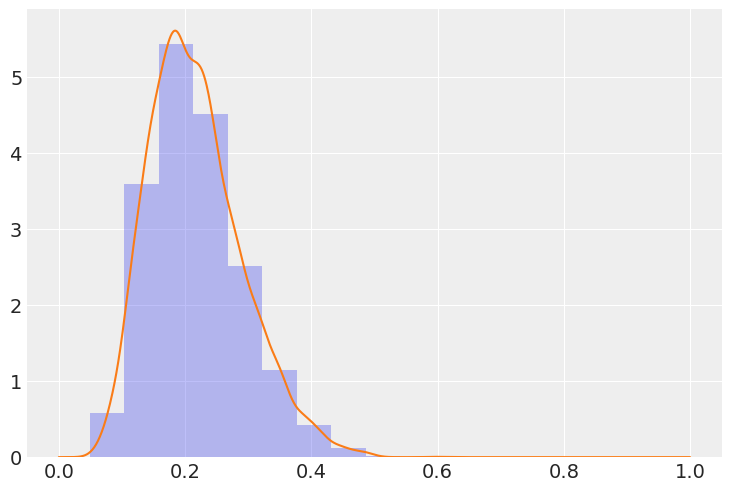

In [36]:
plt.hist(prob, density=True, alpha=0.3)
kde = stats.gaussian_kde(prob)
xx = np.linspace(0, 1, 1000)
plt.plot(xx, kde(xx));

## Compare results for authors who are nominates for 2023 Nebula Award (May 13)

In [37]:
X_new0 = np.array(df_new.T[0]) # chose your fighter
X_new0 = np.hstack([np.ones(1), X_new0])
prob0 = logistic.cdf(w_trace.dot(X_new0))

X_new1 = np.array(df_new.T[1]) # chose your fighter
X_new1 = np.hstack([np.ones(1), X_new1])
prob1 = logistic.cdf(w_trace.dot(X_new1))

X_new2 = np.array(df_new.T[2]) # chose your fighter
X_new2 = np.hstack([np.ones(1), X_new2])
prob2 = logistic.cdf(w_trace.dot(X_new2))

X_new3 = np.array(df_new.T[3]) # chose your fighter
X_new3 = np.hstack([np.ones(1), X_new3])
prob3 = logistic.cdf(w_trace.dot(X_new3))

X_new4 = np.array(df_new.T[4]) # chose your fighter
X_new4 = np.hstack([np.ones(1), X_new4])
prob4 = logistic.cdf(w_trace.dot(X_new4))

X_new5 = np.array(df_new.T[5]) # chose your fighter
X_new5 = np.hstack([np.ones(1), X_new5])
prob5 = logistic.cdf(w_trace.dot(X_new5))

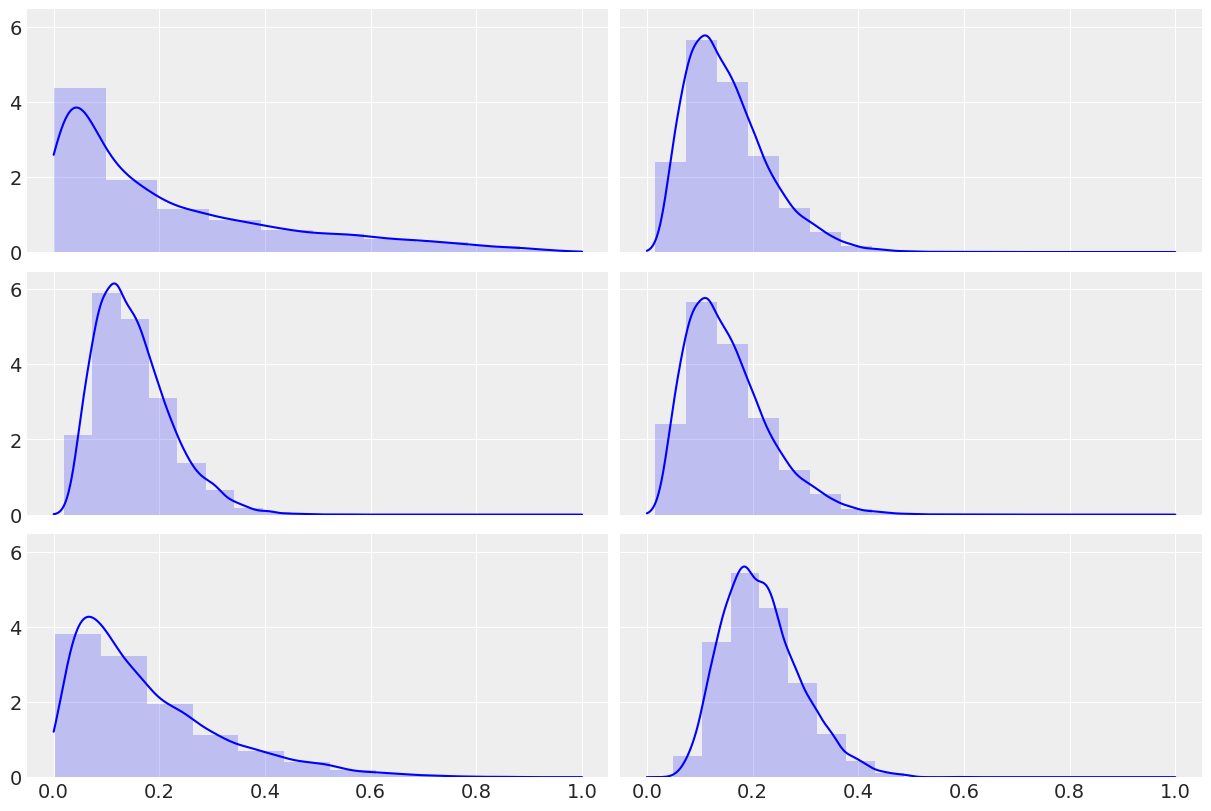

In [38]:
fig, ax = plt.subplots(3, 2, sharex='all', sharey='all', figsize=(12,8))
 
ax0 = ax[0, 0]
ax0.hist(prob0, density=True, color = 'blue', alpha=0.2)
kde0 = stats.gaussian_kde(prob0)
ax0.plot(xx, kde0(xx), color = 'blue');
 
ax1 = ax[0, 1]
ax1.hist(prob1, density=True, color = 'blue', alpha=0.2)
kde1 = stats.gaussian_kde(prob1)
ax1.plot(xx, kde1(xx), color = 'blue');
 
ax2 = ax[1, 0]
ax2.hist(prob2, density=True, color = 'blue', alpha=0.2)
kde2 = stats.gaussian_kde(prob2)
ax2.plot(xx, kde2(xx), color = 'blue');
 
ax3 = ax[1, 1]
ax3.hist(prob3, density=True, color = 'blue', alpha=0.2)
kde3 = stats.gaussian_kde(prob3)
ax3.plot(xx, kde3(xx), color = 'blue');

ax4 = ax[2, 0]
ax4.hist(prob4, density=True, color = 'blue', alpha=0.2)
kde4 = stats.gaussian_kde(prob4)
ax4.plot(xx, kde4(xx), color = 'blue');
 
ax5 = ax[2, 1]
ax5.hist(prob5, density=True, color = 'blue', alpha=0.2)
kde5 = stats.gaussian_kde(prob5)
ax5.plot(xx, kde5(xx), color = 'blue');
 
plt.show()

Plots above show that $6^{th}$ author has highest possibility to win. But chances are close enough for award to be honest.